In [1]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, FlowMatchEulerDiscreteScheduler
from transformers import AutoTokenizer, AutoModel,AutoModelForCausalLM
from PIL import Image
import math

# ====== Настройки ======
dtype = torch.float16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Загрузка моделей ======
vae = AutoencoderKL.from_pretrained(
    "AiArtLab/sdxs3d", subfolder="vae", torch_dtype=dtype
).to(device).eval()

unet = UNet2DConditionModel.from_pretrained(
    #"AiArtLab/sdxs3d" 
    "/workspace/sdxs3d" 
    , subfolder="unet", torch_dtype=dtype
).to(device).eval()

tokenizer = AutoTokenizer.from_pretrained("/workspace/sdxs3d" #"AiArtLab/sdxs3d"
                                          , subfolder="tokenizer")
text_model = AutoModel.from_pretrained("/workspace/sdxs3d" #"AiArtLab/sdxs3d"
                                       , subfolder="text_encoder").to(device).eval()

# ====== FlowMatch Scheduler ======
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained("AiArtLab/sdxs3d", subfolder="scheduler")
print('loaded')



loaded


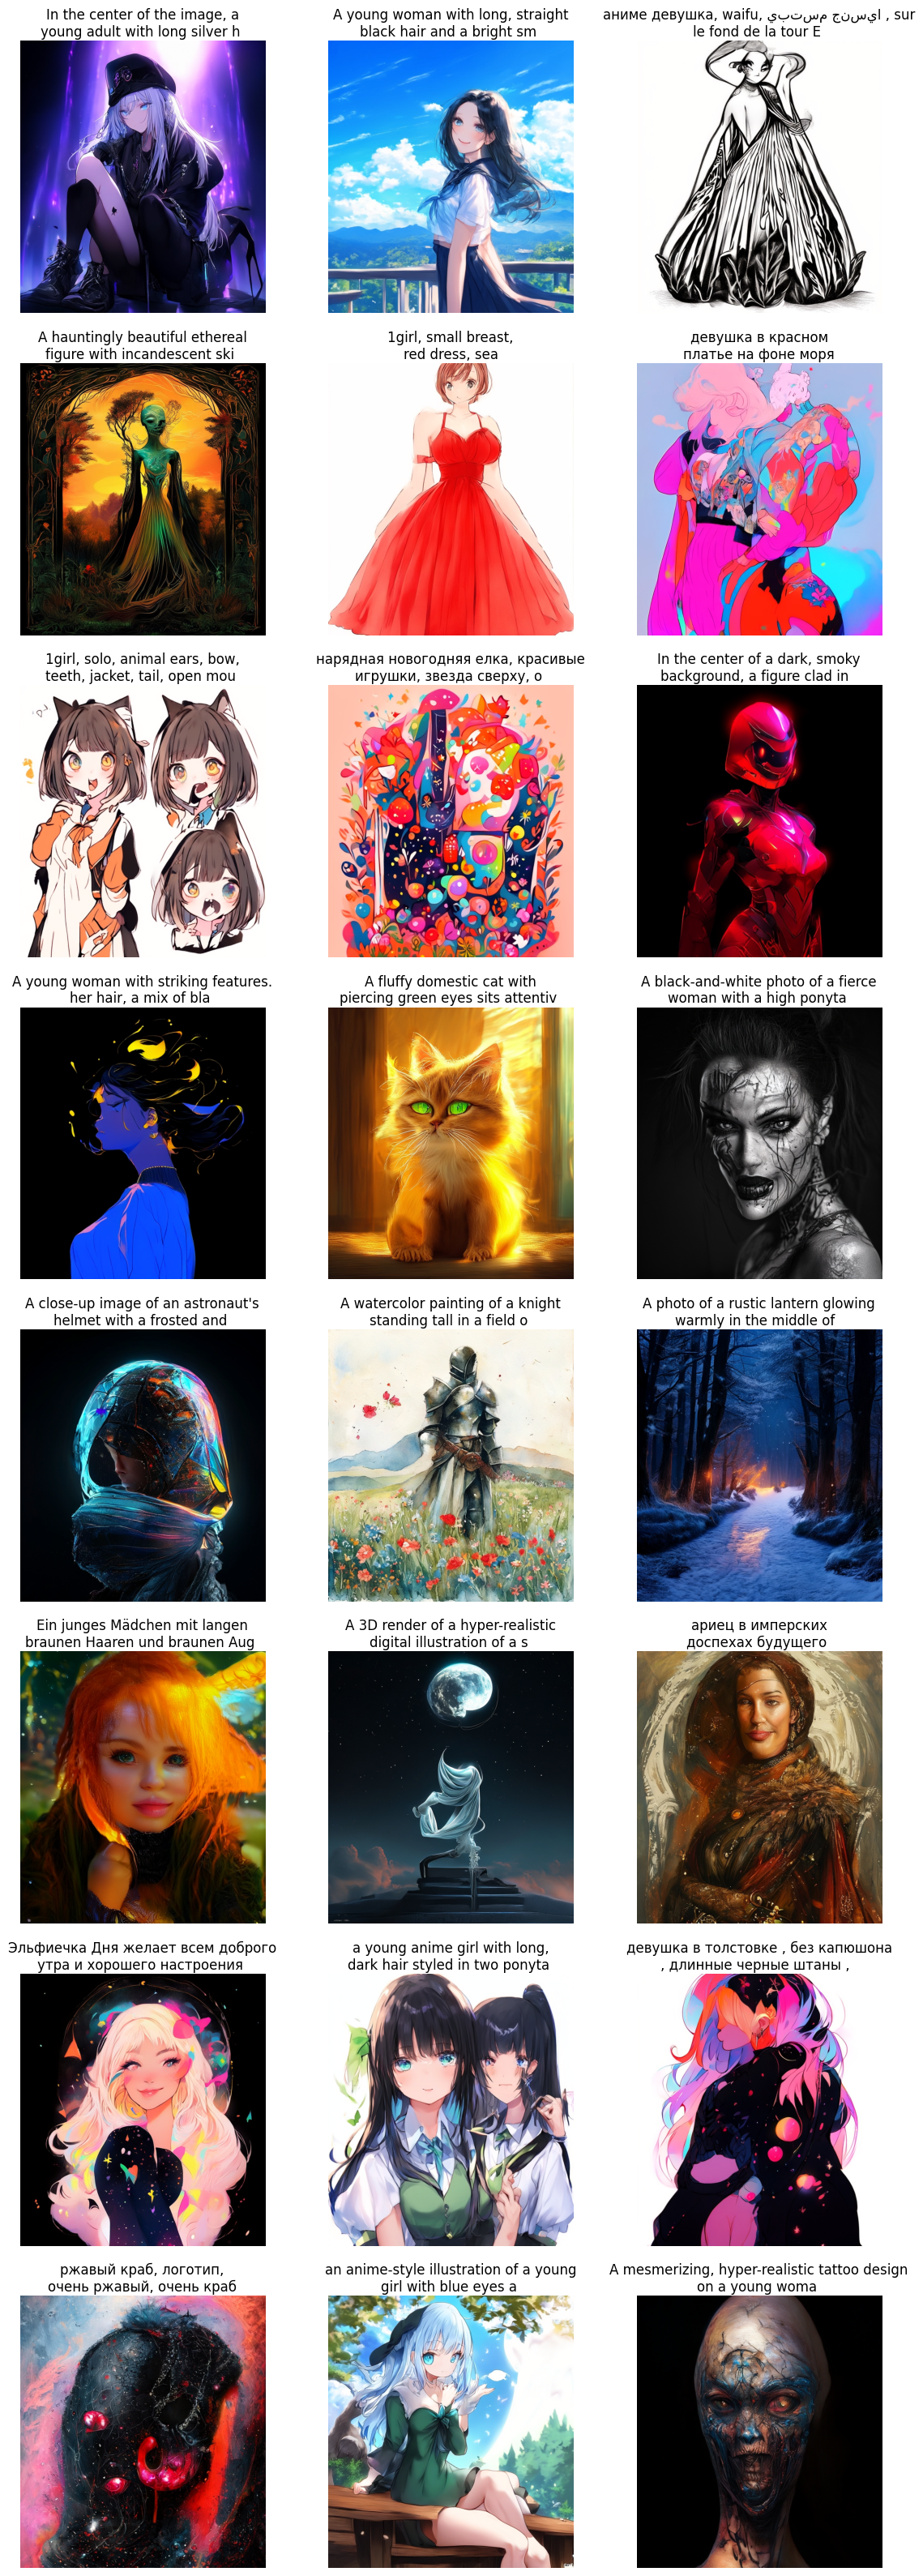

In [2]:
import torch.nn.functional as F


def encode_texts(texts, max_length=150):
    with torch.inference_mode():
        toks = tokenizer(
            texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length
        ).to(device)

        outputs = text_model(**toks, output_hidden_states=True)

        # Берем последний слой (эмбеддинги всех токенов)
        hidden_states = outputs.hidden_states[-1]  # [B, L, D]
        return hidden_states


@torch.no_grad()
def generate_images(
    prompts,
    neg_prompts=None,
    width=384,
    height=384,
    num_inference_steps=40,
    guidance_scale=1.0,
    generator=None,
):
    """
    Генерация изображений с использованием FlowMatchEulerDiscreteScheduler из diffusers.
    Всё вычисление происходит в half-precision.
    """
    vae_scale_factor = 8
    latents_shape = (
        len(prompts),
        unet.config.in_channels,
        height // vae_scale_factor,
        width // vae_scale_factor,
    )

    # Инициализация scheduler

    scheduler.set_timesteps(num_inference_steps, device=device)

    # Инициализация латентов
    latents = torch.randn(
        latents_shape,
        device=device,
        dtype=torch.float16,
        generator=generator,
    )

    # Эмбеддинги промптов
    text_emb = encode_texts(prompts).to(dtype=torch.float16, device=device)
    if neg_prompts is None:
        neg_prompts = [""] * len(prompts)
    uncond_emb = encode_texts(neg_prompts).to(dtype=torch.float16, device=device)

    # Подготовка латентов и эмбеддингов для guidance
    if guidance_scale != 1.0:
        latent_input = torch.cat([latents, latents])
        text_emb_input = torch.cat([uncond_emb, text_emb])
    else:
        latent_input = latents
        text_emb_input = text_emb

    # Интеграция по таймстепам с использованием scheduler
    for t in scheduler.timesteps:
        #print(t_batch)
        flow = unet(
            latent_input.half(),
            t,
            encoder_hidden_states=text_emb_input.half(),
        ).sample.half()

        if guidance_scale != 1.0:
            flow_uncond, flow_cond = flow.chunk(2)
            flow = flow_uncond + guidance_scale * (flow_cond - flow_uncond)

        # Обновление латентов
        latents = scheduler.step(flow, t, latents).prev_sample

        # Обновление latent_input для следующего шага
        if guidance_scale != 1.0:
            latent_input = torch.cat([latents, latents])

    # Декодирование латентов в изображения
    latents_for_vae = latents / vae.config.scaling_factor
    images = vae.decode(latents_for_vae.half()).sample.half()

    # Конвертация в PIL
    images = (images.float() / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    pil_images = []
    for img in images:
        img = (img * 255).round().astype("uint8")
        pil_images.append(Image.fromarray(img))

    return pil_images

def display_grid(images, cols=2):
    rows = math.ceil(len(images) / cols)
    w, h = images[0].size
    grid = Image.new("RGB", (cols * w, rows * h))
    for i, img in enumerate(images):
        grid.paste(img, (i % cols * w, i // cols * h))
    return grid

import matplotlib.pyplot as plt
import math

import matplotlib.pyplot as plt
import math

def display_image_grid(images, prompts, cols=4, save_path=None):
    """Отображение грида изображений с подписями и возможностью сохранения"""
    n = len(images)
    rows = math.ceil(n / cols)

    # Создаем фигуру
    fig = plt.figure(figsize=(cols * 4, rows * 4))

    # Отображаем изображения
    for i, (img, prompt) in enumerate(zip(images, prompts)):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)

        # Обрезаем длинные промпты
        truncated_prompt = prompt[:60] + " " if len(prompt) > 60 else prompt

        # Разделяем промпт на две строки
        lines = truncated_prompt.split(' ')
        half = len(lines) // 2
        line1 = ' '.join(lines[:half])
        line2 = ' '.join(lines[half:])

        # Устанавливаем заголовок с двумя строками и увеличенным размером шрифта
        ax.set_title(f'{line1}\n{line2}', fontsize=12, wrap=True)
        ax.axis('off')

    # Улучшаем расположение
    plt.tight_layout(pad=1.5)

    # Сохраняем если нужно
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', format='jpeg', dpi=500)

    plt.show()

# ====== Пример использования ======
prompts = [
    "In the center of the image, a young adult with long silver hair and striking blue eyes is the focal point. The individual is squatting down, exuding a cool vibe, and is actively engaged in a performance. They are holding a microphone in their right hand, suggesting they are either singing or rapping. The person is dressed in a casual yet stylish outfit, featuring a black jacket, black baseball cap, and black thigh-high boots. The background is a dark, indoor setting with a purple hue, and there are beams of light shining down, adding a dramatic effect to the scene. The person's expression is one of concentration, indicating their focus on the performance."
    ,"A young woman with long, straight black hair and a bright smile stands on a balcony, wearing a white shirt and a blue sailor collar, with a picturesque view of a mountain range and a clear blue sky in the background."
    ,'аниме девушка, waifu, يبتسم جنسيا , sur le fond de la tour Eiffel'
    ,"A hauntingly beautiful ethereal figure with incandescent skin stands in a twilight forest, her form partially decaying yet radiating an inner light. Her silhouette blends elements of Art Nouveau elegance and cybernetic futurism, evoking the styles of Sorayama and Beksinski. Warm hues of sunset glow through the misty canopy, casting a golden light on the intricate details of her decaying flesh and metallic enhancements. In the background, surreal, ghostly trees with vibrant autumn leaves create a melancholic atmosphere, reminiscent of the works by Rockwell and Parrish."
    ,"1girl, small breast, red dress, sea"
    ,"девушка в красном платье на фоне моря"
    ,"1girl, solo, animal ears, bow, teeth, jacket, tail, open mouth, brown hair, orange background, bowtie, orange nails, simple background, cat ears, orange eyes, blue bow, animal ear fluff, cat tail, looking at viewer, upper body, shirt, school uniform, hood, striped bow, striped, white shirt, black jacket, blue bowtie, fingernails, long sleeves, cat girl, bangs, fangs, collared shirt, striped bowtie, short hair, tongue, hoodie, sharp teeth, facial mark, claw pose"
    ,"нарядная новогодняя елка, красивые игрушки, звезда сверху, огоньки, на тёмном фоне"
    ,"In the center of a dark, smoky background, a figure clad in a vibrant red bodysuit stands out. The suit is adorned with intricate designs and armor plating, giving it a formidable appearance. The helmet, matching the suit, features a visor with glowing red eyes, adding to the mysterious aura of the character."
    ,"A young woman with striking features. her hair, a mix of black and gold, floats around her head, adding a sense of movement to the scene. her eyes, a vibrant yellow, are half-closed, giving her a contemplative expression. she is dressed in a blue sweater, which contrasts with the black background. the overall composition of the image is simple yet striking, with the womans profile taking center stage"
    ,'A fluffy domestic cat with piercing green eyes sits attentively in a sunlit room filled natural light streaming through large windows, its soft fur reflecting warm hues of orange from the golden glow casting across its sleek body and delicate features'
    ,"A black-and-white photo of a fierce woman with a high ponytail wearing a spiked iron mask. The mask's sharp, metallic spikes add a menacing aura, contrasting with her soft yet intense expression. Her skin is marked with dirt, showcasing the aftermath of her battles, but her eyes reveal determination and strength. The spiked mask captures her mysterious and intimidating nature, adding to the intensity of the moment."
    ,"A close-up image of an astronaut's helmet with a frosted and opaque visor. The visor reflects the cold, frozen texture of space. Resting on the surface of the visor is a butterfly with vibrant, intricately patterned wings. The contrast between the delicate natural beauty of the butterfly and the cold, industrial helmet creates a striking image. The butterfly adds a touch of fragility and life to the otherwise harsh and unfeeling setting. The faint glow of distant stars can be seen through the frost, further enhancing the surreal atmosphere."
    ,"A watercolor painting of a knight standing tall in a field of wildflowers. The knight's armor is a mixture of soft greys and silvers, and he holds a large red rose. The background is a hazy wash of pale blue skies and distant mountains. The knight's strong yet serene posture creates an intriguing contrast between the image of a warrior and the delicate beauty of the flowers."
    ,"A photo of a rustic lantern glowing warmly in the middle of a snow-covered forest trail. The trail is lined with tall, snow-covered trees with faint branches. Soft falling snowflakes are visible, creating a serene atmosphere. The background is dark and mysterious. The overall image has a sense of solitude and magic."
    ,"Ein junges Mädchen mit langen braunen Haaren und braunen Augen steht an einer Backsteinwand, trägt ein weißes Hemd mit einem schwarzen Matrosenkragen und einen schwarzen Faltenrock. Sie lächelt und schaut direkt zum Betrachter, während Sonnenlicht durch die grünen Ranken hinter ihr fällt."
    ,"A 3D render of a hyper-realistic digital illustration of a surreal, moonlit scene. A silhouette of a mannequin man is climbing a delicate ladder suspended in an infinite gray twilight. The ladder is attached to a cloud. The background is a vast, starry sky with a crescent moon. The malemannequin is reaching for a glowing star."
    ,"ариец в имперских доспехах будущего "
    ,"Эльфиечка Дня желает всем доброго утра и хорошего настроения!"
    ,"a young anime girl with long, dark hair styled in two ponytails. She is wearing a white collared shirt and a green bow tie. In the background, there are two additional characters, one of whom is holding a hairbrush and the other is looking at the girl. The girl's expression appears to be one of sadness or disappointment. Pentagon Pixiv"
    ,"девушка в толстовке , без капюшона , длинные черные штаны , карие глаза, светлые волосы, anime, bloody theme "
    ,"ржавый краб, логотип, очень ржавый, очень краб"
    ,"an anime-style illustration of a young girl with blue eyes and white hair, wearing a green dress and a black bow in her hair. She is sitting on a wooden bench, with a full moon in the background and a tree in the distance. The girl is holding a small white object in her hand, and there are two more white objects in the background. Konpaku Youmu Myon Sazanami Mio.jpg, Touhou"
    ,"A mesmerizing, hyper-realistic tattoo design on a young woman's back, depicting an alien creature seemingly breaking out of her skin. The tattoo is highly detailed, with the alien's body, limbs, and facial features rendered in intricate detail. The woman's skin appears to have a translucent quality, revealing the intricate anatomy of the alien creature beneath. The overall mood of the image is eerie yet captivating, with the alien's sharp, glowing eyes piercing through the darkness."
]

prompts2 = ["cat","dog"]
neg_prompts = ["bad quality, low quality, low resolution"] * len(prompts)
#neg_prompts = [""] * len(prompts)

# Исправленный вызов функции с правильными параметрами
images = generate_images(
    prompts, 
    neg_prompts=neg_prompts, 
    guidance_scale=4.0, 
    num_inference_steps=50, 
    height=640, 
    width=576,
    generator = torch.Generator(device=device).manual_seed(42)
)

grid = display_image_grid(images,prompts, cols=3, save_path="result_grid2.png")


In [5]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, FlowMatchEulerDiscreteScheduler
from transformers import AutoTokenizer, AutoModel
from PIL import Image
import math

# ====== Настройки ======
dtype = torch.float16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = UNet2DConditionModel.from_pretrained( "/workspace/sdxs3d"#"AiArtLab/sdxs3d"
                                            , subfolder="unet", torch_dtype=dtype
).to(device).eval()

unet.save_pretrained("/workspace/sdxs3d/unet")
print("ok")

ok


In [6]:
import gradio as gr
import numpy as np
import random

import spaces #[uncomment to use ZeroGPU]
import torch

from diffusers import DiffusionPipeline, AutoencoderKL, UNet2DConditionModel, FlowMatchEulerDiscreteScheduler
from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model_repo_id = "AiArtLab/sdxs3d"  # Replace to the model you would like to use

if torch.cuda.is_available():
    dtype = torch.float16
else:
    dtype = torch.float32


class SimpleDiffusionPipeline(DiffusionPipeline):
    def __init__(self, vae, text_encoder, tokenizer, unet, scheduler):
        super().__init__()
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt,
        negative_prompt=None,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=4.0,
        generator=None,
        **kwargs,
    ):
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # 1. Токенизация
        toks = self.tokenizer(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(self.device)

        outs = self.text_encoder(**toks)
        text_emb = outs.last_hidden_state[:, -1].unsqueeze(1)  

        if negative_prompt is not None:
            neg_toks = self.tokenizer(
                negative_prompt,
                padding="max_length",
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(self.device)
            neg_outs = self.text_encoder(**neg_toks)
            neg_emb = neg_outs.last_hidden_state[:, -1].unsqueeze(1)
        else:
            neg_emb = torch.zeros_like(text_emb)

        # guidance
        if guidance_scale != 1.0:
            text_emb = torch.cat([neg_emb, text_emb])

        # 2. Латенты
        latents = torch.randn(
            (batch_size, self.unet.config.in_channels, height // self.vae.config.scaling_factor, width // self.vae.config.scaling_factor),
            device=self.device,
            dtype=torch.float16,
            generator=generator,
        )

        self.scheduler.set_timesteps(num_inference_steps, device=self.device)

        # 3. Диффузия
        for t in self.scheduler.timesteps:
            latent_input = torch.cat([latents, latents]) if guidance_scale != 1.0 else latents
            flow = self.unet(latent_input, t, encoder_hidden_states=text_emb).sample

            if guidance_scale != 1.0:
                flow_uncond, flow_cond = flow.chunk(2)
                flow = flow_uncond + guidance_scale * (flow_cond - flow_uncond)

            latents = self.scheduler.step(flow, t, latents).prev_sample

        # 4. Декод
        latents = latents / self.vae.config.scaling_factor
        images = self.vae.decode(latents).sample
        images = (images / 2 + 0.5).clamp(0, 1)

        return images


vae = AutoencoderKL.from_pretrained(model_repo_id, subfolder="vae", torch_dtype=dtype).to(device)
unet = UNet2DConditionModel.from_pretrained(model_repo_id, subfolder="unet", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_repo_id, subfolder="tokenizer")
text_encoder = AutoModel.from_pretrained(model_repo_id, subfolder="text_encoder", torch_dtype=dtype).to(device)
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(model_repo_id, subfolder="scheduler")

pipe = SimpleDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
).to(device)


MAX_SEED = np.iinfo(np.int32).max
MAX_IMAGE_SIZE = 384


@spaces.GPU #[uncomment to use ZeroGPU]
def infer(
    prompt,
    negative_prompt,
    seed,
    randomize_seed,
    width,
    height,
    guidance_scale,
    num_inference_steps,
    progress=gr.Progress(track_tqdm=True),
):
    if randomize_seed:
        seed = random.randint(0, MAX_SEED)

    generator = torch.Generator(device=device).manual_seed(seed)  # ← используйте seed, а не 42!

    # Генерация
    images_tensor = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        width=width,
        height=height,
        generator=generator,
    )  # [B, C, H, W]

    # Конвертация в numpy для Gradio
    image = images_tensor[0].cpu().permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)

    return image, seed


examples = [
    "A delicious ceviche cheesecake slice",
    "ариец в имперских доспехах будущего",
    "A close-up image of an astronaut's helmet with a frosted and opaque visor. The visor reflects the cold, frozen texture of space. Resting on the surface of the visor is a butterfly with vibrant, intricately patterned wings. The contrast between the delicate natural beauty of the butterfly and the cold, industrial helmet creates a striking image. The butterfly adds a touch of fragility and life to the otherwise harsh and unfeeling setting. The faint glow of distant stars can be seen through the frost, further enhancing the surreal atmosphere.",    
]

css = """
#col-container {
    margin: 0 auto;
    max-width: 640px;
}
"""

with gr.Blocks(css=css) as demo:
    with gr.Column(elem_id="col-container"):
        gr.Markdown(" # Text-to-Image Gradio Template")

        with gr.Row():
            prompt = gr.Text(
                label="Prompt",
                show_label=False,
                max_lines=1,
                placeholder="Enter your prompt",
                container=False,
            )

            run_button = gr.Button("Run", scale=0, variant="primary")

        result = gr.Image(label="Result", show_label=False)

        with gr.Accordion("Advanced Settings", open=False):
            negative_prompt = gr.Text(
                label="Negative prompt",
                max_lines=1,
                placeholder="Enter a negative prompt",
                visible=True,
                value ="low quality"
            )

            seed = gr.Slider(
                label="Seed",
                minimum=0,
                maximum=MAX_SEED,
                step=1,
                value=0,
            )

            randomize_seed = gr.Checkbox(label="Randomize seed", value=True)

            with gr.Row():
                width = gr.Slider(
                    label="Width",
                    minimum=192,
                    maximum=MAX_IMAGE_SIZE,
                    step=64,
                    value=256,  # Replace with defaults that work for your model
                )

                height = gr.Slider(
                    label="Height",
                    minimum=192,
                    maximum=MAX_IMAGE_SIZE,
                    step=64,
                    value=384,  # Replace with defaults that work for your model
                )

            with gr.Row():
                guidance_scale = gr.Slider(
                    label="Guidance scale",
                    minimum=0.0,
                    maximum=10.0,
                    step=0.1,
                    value=4.0,  # Replace with defaults that work for your model
                )

                num_inference_steps = gr.Slider(
                    label="Number of inference steps",
                    minimum=1,
                    maximum=50,
                    step=1,
                    value=40,  # Replace with defaults that work for your model
                )

        gr.Examples(examples=examples, inputs=[prompt])
    gr.on(
        triggers=[run_button.click, prompt.submit],
        fn=infer,
        inputs=[
            prompt,
            negative_prompt,
            seed,
            randomize_seed,
            width,
            height,
            guidance_scale,
            num_inference_steps,
        ],
        outputs=[result, seed],
    )

if __name__ == "__main__":
    demo.launch()

ModuleNotFoundError: No module named 'gradio'